###  Clustering


In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [3]:
n_clusters= 6
n_samples = 250

In [ ]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [ ]:
def sample(m): return MultivariateNormal(
    m,
    torch.diag(tensor([5.,5]))
).sample((n_samples,))

In [ ]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

In [8]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='m', mew=2)

In [35]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [39]:
# Note Umer: dist, but for a batch of points
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

### Homwork

Implement k-means clustering / dbscan / locality sensitive hashing on GPU

#### k-means

Pseudocode for K-Means Clustering (adapted from [src](https://towardsdatascience.com/k-means-clustering-introduction-to-machine-learning-algorithms-c96bf0d5d57a))

1. Choose K = # clusters, and obtain the data points 
2. Place K centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End 

Plan:
- create centroids (or use from above)
- do one update
- loop

In [60]:
X = data.clone().cuda()
x = X[0]
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([2]))

Goal: find_nearest_cluster

In [61]:
centroids = centroids.cuda()

In [62]:
dist_b(centroids,X[:2]).shape, dist_b(centroids,X[:2])

(torch.Size([2, 6]),
 tensor([[ 2.76, 34.89, 38.98, 43.63, 52.23, 20.24],
         [ 1.58, 33.95, 40.61, 43.81, 56.13, 24.13]], device='cuda:0'))

In [63]:
torch.min(dist_b(centroids,X[:2]), axis=1)

torch.return_types.min(
values=tensor([2.76, 1.58], device='cuda:0'),
indices=tensor([0, 0], device='cuda:0'))

In [64]:
torch.argmin(dist_b(centroids,X[:2]), axis=1)

tensor([0, 0], device='cuda:0')

In [65]:
def nearest_centroid_b(centroids,x): return torch.argmin(dist_b(centroids,x),axis=1)

In [66]:
nearest_centroid_b(centroids,X[:2])

tensor([0, 0], device='cuda:0')

In [67]:
# def do_one_step

# for all data points: find nearest centroids
# move centroids

In [68]:
nearest_centroids = nearest_centroid_b(centroids,X[:10])
nearest_centroids

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [69]:
X[:10][nearest_centroids==0].sum(axis=0)

tensor([273.08, 294.17], device='cuda:0')

In [70]:
def do_one_step(centroids, X):  # K,2 | n_samples,2 
    # to gpu
    centroids = centroids.cuda()
    X = X.cuda()
    # find nearest centroids
    nearest_centroids = nearest_centroid_b(centroids,X)  # n_samples, K
    # reposition centroids:
    for k in range(len(centroids)): centroids[k] = X[nearest_centroids==k].mean(axis=0)
    return centroids  # K,2

In [71]:
def random_centroids(K): return torch.rand(K, 2)*70-35

In [72]:
my_centroids = random_centroids(K=6)
my_centroids

tensor([[ -7.81, -21.11],
        [-15.16,   2.18],
        [ -6.22,  16.94],
        [-19.37,  -9.96],
        [-34.69,  28.57],
        [ -6.59, -27.59]])

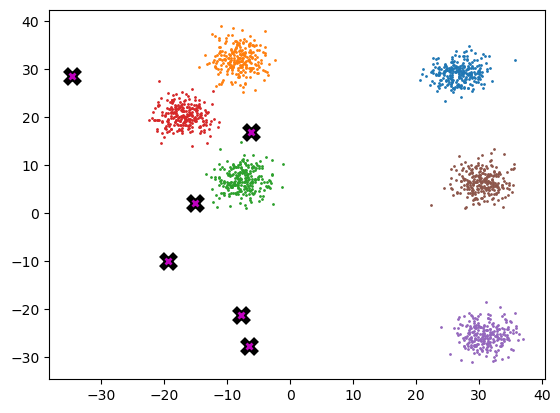

In [73]:
plot_data(my_centroids.cpu(), X.cpu(), n_samples)

Now let's check if doing multiple steps also works.

In [74]:
for _ in range(5):
    do_one_step(my_centroids, X)
    print(my_centroids[:1])

tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])
tensor([[ -7.81, -21.11]])


In [75]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [76]:
def do_one(d):
    if d: do_one_step(my_centroids, X)
    ax.clear()
    plot_data(my_centroids.cpu()+2, X.cpu(), n_samples, ax=ax)

fig,ax = plt.subplots()
ani = FuncAnimation(fig,do_one,frames=5,repeat=False)
plt.close()
HTML(ani.to_jshtml())